In [1]:
# Install required packages
import sys, os
import numpy as np
import scipy.spatial as sp
from sklearn.preprocessing import normalize
from IPython.display import display, clear_output
from IPython.display import Markdown
import pandas as pd
from collections import namedtuple
from itertools import product, permutations
import matplotlib.pyplot as plt
import random
import copy
import ipympl

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Import pyomo environment and setup gurobi solver
import pyomo.environ as pyo
import gurobipy 
solver = pyo.SolverFactory("gurobi_direct")

In [2]:
'''
Sample pertubations of instance
Args:     orig          - array of original instance
          index_list    - list with indices of originial array to perturb
          method        - method to perturb instance. Only option now: normal
          var           - variance for pertubation
          size          - number of perturbed instances
Output:   org_plus_smpl - array with rows original instance and size perturbed instances
'''

def sample_perturbations(orig, index_list, method = 'normal', var = 0.2, size = 1000):
    
    mean = 0
    var = 0.2
    eps = 0.1
    org_plus_prtb = []
    prtb = []
    
    for i in range(size):
        orig_with_noise = copy.deepcopy(orig)
        prtb.append([])
        
        for j in range(len(orig)):
            if j in index_list:
                if method == 'normal':
                    sigma = orig_with_noise[j] * var
                    orig_with_noise[j] = orig_with_noise[j] + np.random.normal(mean, sigma)
                elif method == 'epsilon':
                    lmb = np.random.uniform(-1, 1)
                    orig_with_noise[j] = orig_with_noise[j] + lmb * eps
                    prtb[i].append(lmb)
                elif method == 'scaling':
                    lmb = np.random.uniform(0.2, 1.8)
                    orig_with_noise[j] = orig_with_noise[j] * lmb 
                    prtb[i].append(lmb)
                else:
                    return print("Method not supported")
                    

        org_plus_prtb.append(np.asarray(orig_with_noise))
    org_plus_prtb = np.asarray(org_plus_prtb)
    prtb = np.asarray(prtb)

    return org_plus_prtb, prtb

In [14]:
# Compute distance between two vectors and evaluate the kernel function
# kernel_width: kernel width for the exponential kernel.
#                 If None, defaults to sqrt (number of columns) * 0.75

def distance(a, b):
    return np.linalg.norm(a - b)
    
def kernel(a, b, kernel_width = 0.5):
    d = distance(a, b)
    return np.exp(-(d ** 2) / (2* kernel_width ** 2))

# Example 2D parametric
https://application.wiley-vch.de/books/sample/3527316914_c01.pdf

Page 14

Note: no weights, first need to know which instance to explain

In [2]:
def model_ILP_exmpl(thetas, solver = solver):

    # Define a model
    model = pyo.ConcreteModel('Example Literature')

    # Declare decision variables
    model.x = pyo.Var(range(2), domain=pyo.NonNegativeReals)

    # Declare objective
    model.objective = pyo.Objective(expr = 8.1*model.x[0] +10.8*model.x[1],
                                sense = pyo.maximize)

    # Declare constraints
    model.c1 = pyo.Constraint(expr = 0.8*model.x[0] + 0.44*model.x[1]  <= 24000 +thetas[0])
    model.c2 = pyo.Constraint(expr = 0.05*model.x[0] + 0.10*model.x[1]  <= 2000 +thetas[1])
    model.c3 = pyo.Constraint(expr = 0.1*model.x[0] + 0.36*model.x[1]  <= 6000)

    # Solve
    result = solver.solve(model)

    # Store solutions
    solutions = []
    for i in range(2):
        solutions.append(pyo.value(model.x[i]))

    return model.objective()

In [3]:
theta_1 = np.random.uniform(low=0.0, high=6000.0, size=1000)
theta_2 = np.random.uniform(low=0.0, high=500.0, size=1000)

theta_list = np.zeros((1000,2))
solutions = []

for i in range(1000):
    theta_list[i][0] = theta_1[i]
    theta_list[i][1] = theta_2[i]
    solutions.append(model_ILP_exmpl(theta_list[i]))
clf = LinearRegression()
clf.fit(theta_list, solutions)

DTR = DecisionTreeRegressor(max_depth=4, min_samples_leaf=50)
DTR.fit(theta_list, solutions)

DecisionTreeRegressor(max_depth=4, min_samples_leaf=50)

In [4]:
T1 = np.linspace(start = 0, stop = 6000, num=1000)
T2 = np.linspace(start = 0, stop = 500, num=1000)

x, y = np.meshgrid(T1, T2)
model_viz = np.array([x.flatten(), y.flatten()]).T

z_lrg_tmp = clf.predict(model_viz)/10000
z_DTR_tmp = DTR.predict(model_viz)/10000

In [5]:
z_lrg= np.array([z_lrg_tmp[i*len(z_lrg_tmp) // 1000: (i+1)*len(z_lrg_tmp) // 1000] for i in range(1000)])
z_DTR= np.array([z_DTR_tmp[i*len(z_DTR_tmp) // 1000: (i+1)*len(z_DTR_tmp) // 1000] for i in range(1000)])

In [6]:
print(len(x), len(x[0]), len(z_lrg), len(z_lrg[0]))

1000 1000 1000 1000


In [7]:
x, y = np.meshgrid(T1, T2)
z_1 = (4.66*x + 87.52*y + 286758.6)/10000
z_2 = (7.53*x + 305409.84)/10000

z_opt = z_1

for i in range(1000):
    for j in range(1000):
        if  -0.14*x[i][j] + 4.21*y[i][j] >= 896.55:
            z_opt[i][j] = z_2[i][j]


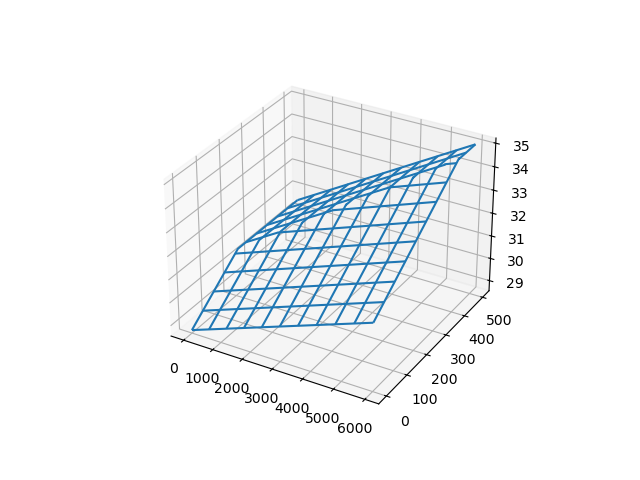

In [8]:
from mpl_toolkits.mplot3d import axes3d
%matplotlib widget 

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# Plot a basic wireframe.
ax.plot_wireframe(x, y, z_opt, rstride=100, cstride=100)
plt.show()

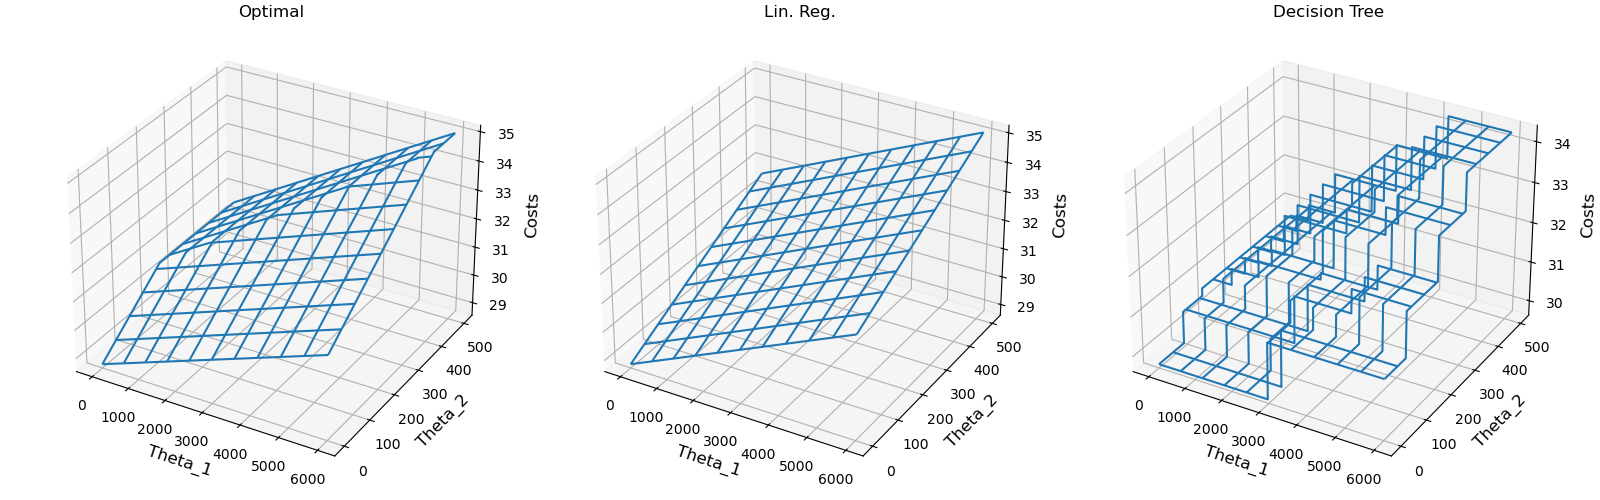

In [9]:
fig = plt.figure(figsize=(16, 5))

ax1 = fig.add_subplot(131, projection='3d')
ax2 = fig.add_subplot(132, projection='3d')
ax3 = fig.add_subplot(133, projection='3d')

axes    = [ax1, ax2, ax3]
z_lst   = [z_opt, z_lrg, z_DTR]
ttl_lst = ['Optimal', 'Lin. Reg.', 'Decision Tree']

for i in range(3):
    ax = axes[i]
    ax.plot_wireframe(x, y, z_lst[i], rstride=100, cstride=100)
    ax.set_xlabel('Theta_1', fontsize=12)
    ax.set_ylabel('Theta_2', fontsize=12)
    ax.set_zlabel('Costs', fontsize=12)
    ax.set_title(ttl_lst[i], fontsize=12)


fig.tight_layout()

Text(0.5, 0.92, "'all methods")

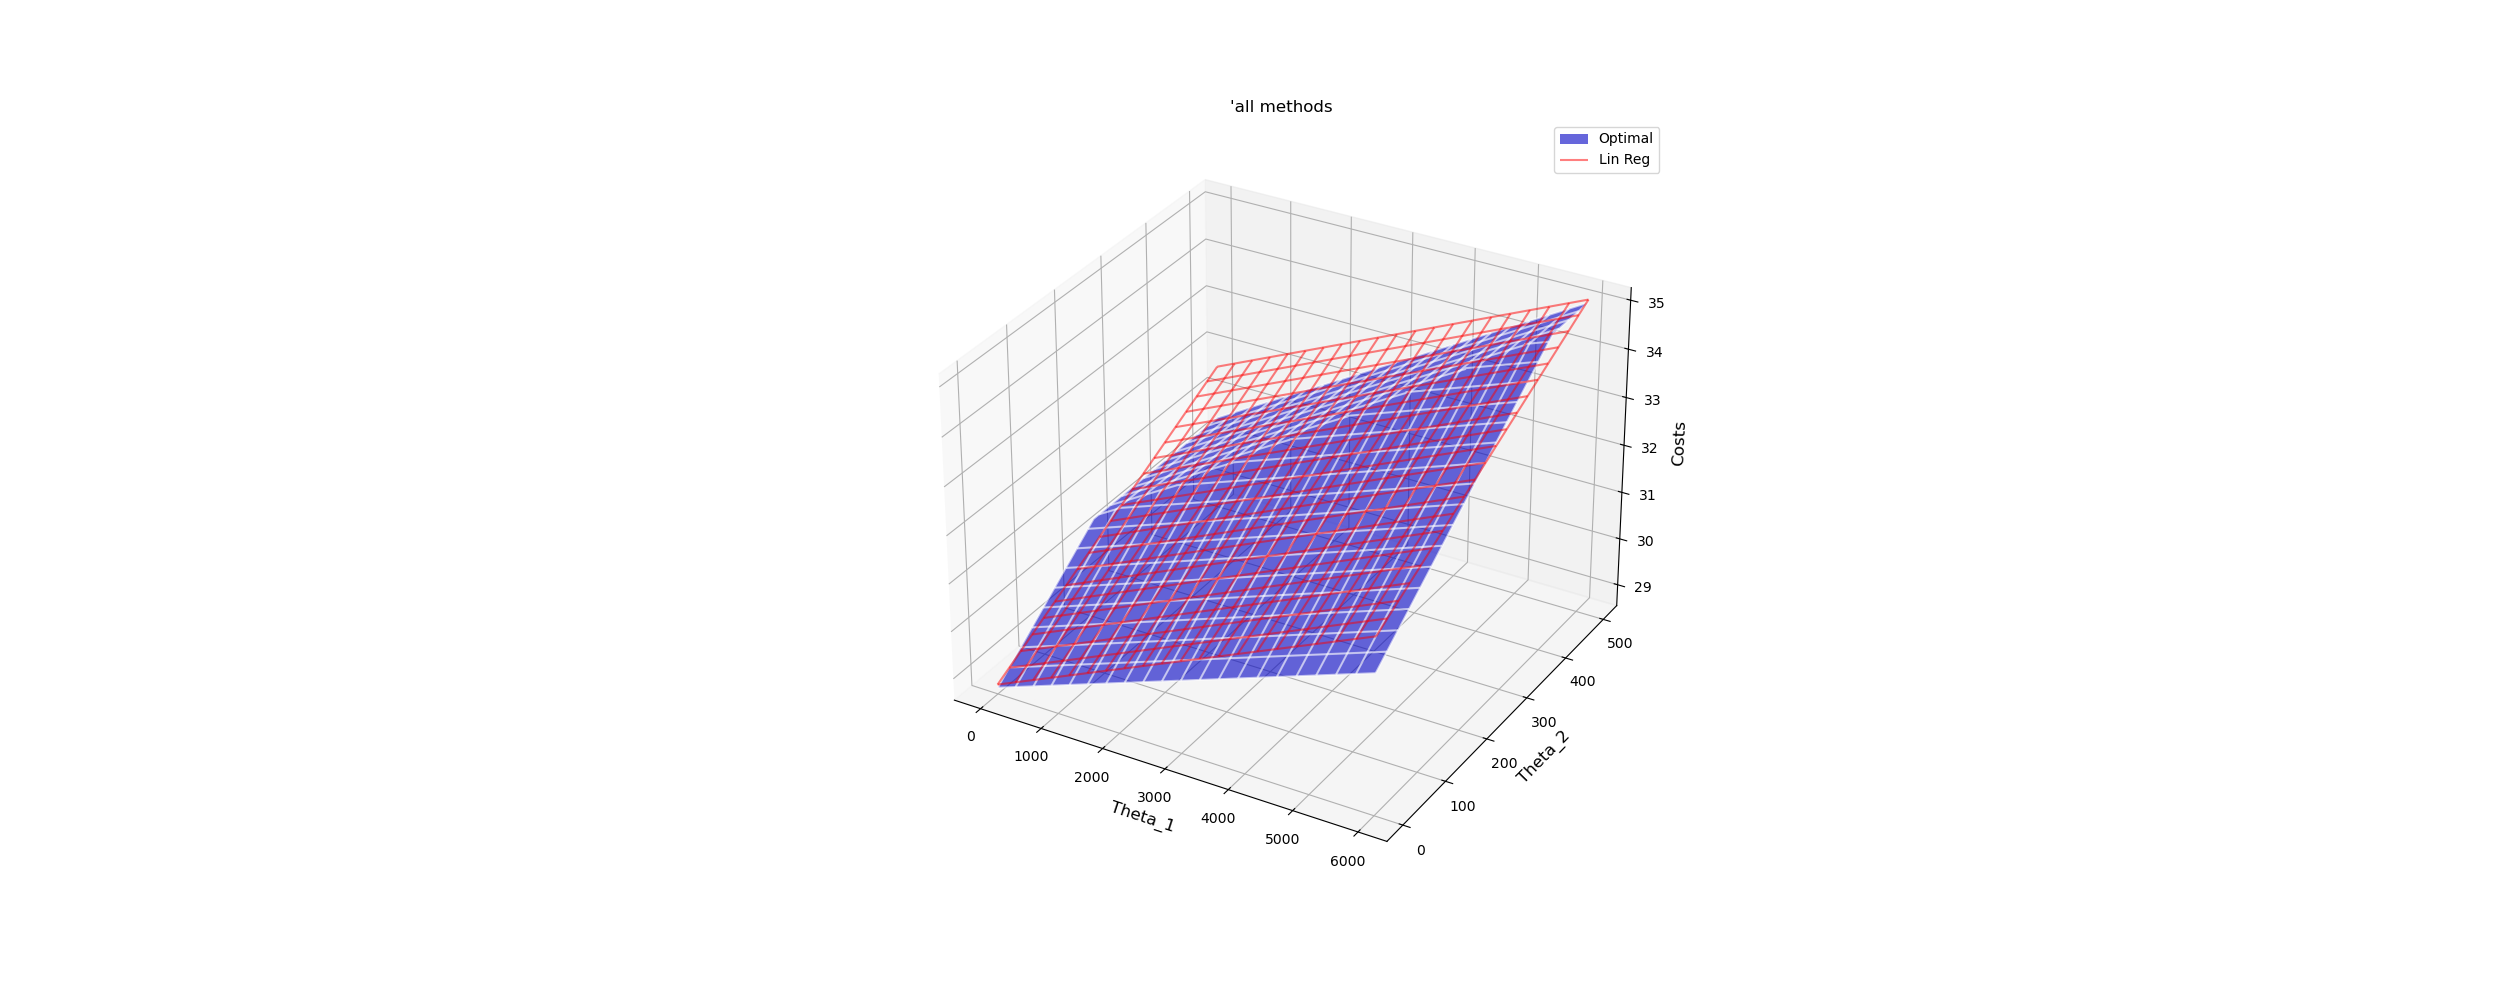

In [10]:
fig = plt.figure(figsize=(25, 10))
ax = fig.add_subplot(projection='3d')

z_lst   = [z_opt, z_lrg, z_DTR]
ttl_lst = ['Optimal', 'Lin. Reg.', 'Decision Tree']


ax.plot_surface(x, y, z_lst[0], rstride=50, cstride=50, label = 'Optimal', color = 'b', alpha = 0.6)
ax.plot_wireframe(x, y, z_lst[0], rstride=50, cstride=50, color = 'white', alpha = 0.6)
ax.plot_wireframe(x, y, z_lst[1], rstride=50, cstride=50, label = 'Lin Reg', color = 'red', alpha = 0.5)
# ax.plot_wireframe(x, y, z_lst[2], rstride=50, cstride=50, label = 'Dec. Tree', color = 'green', alpha=0.5)
ax.set_xlabel('Theta_1', fontsize=12)
ax.set_ylabel('Theta_2', fontsize=12)
ax.set_zlabel('Costs', fontsize=12)
ax.legend()
ax.set_title("'all methods", fontsize=12)


Text(0.5, 0.92, "'all methods")

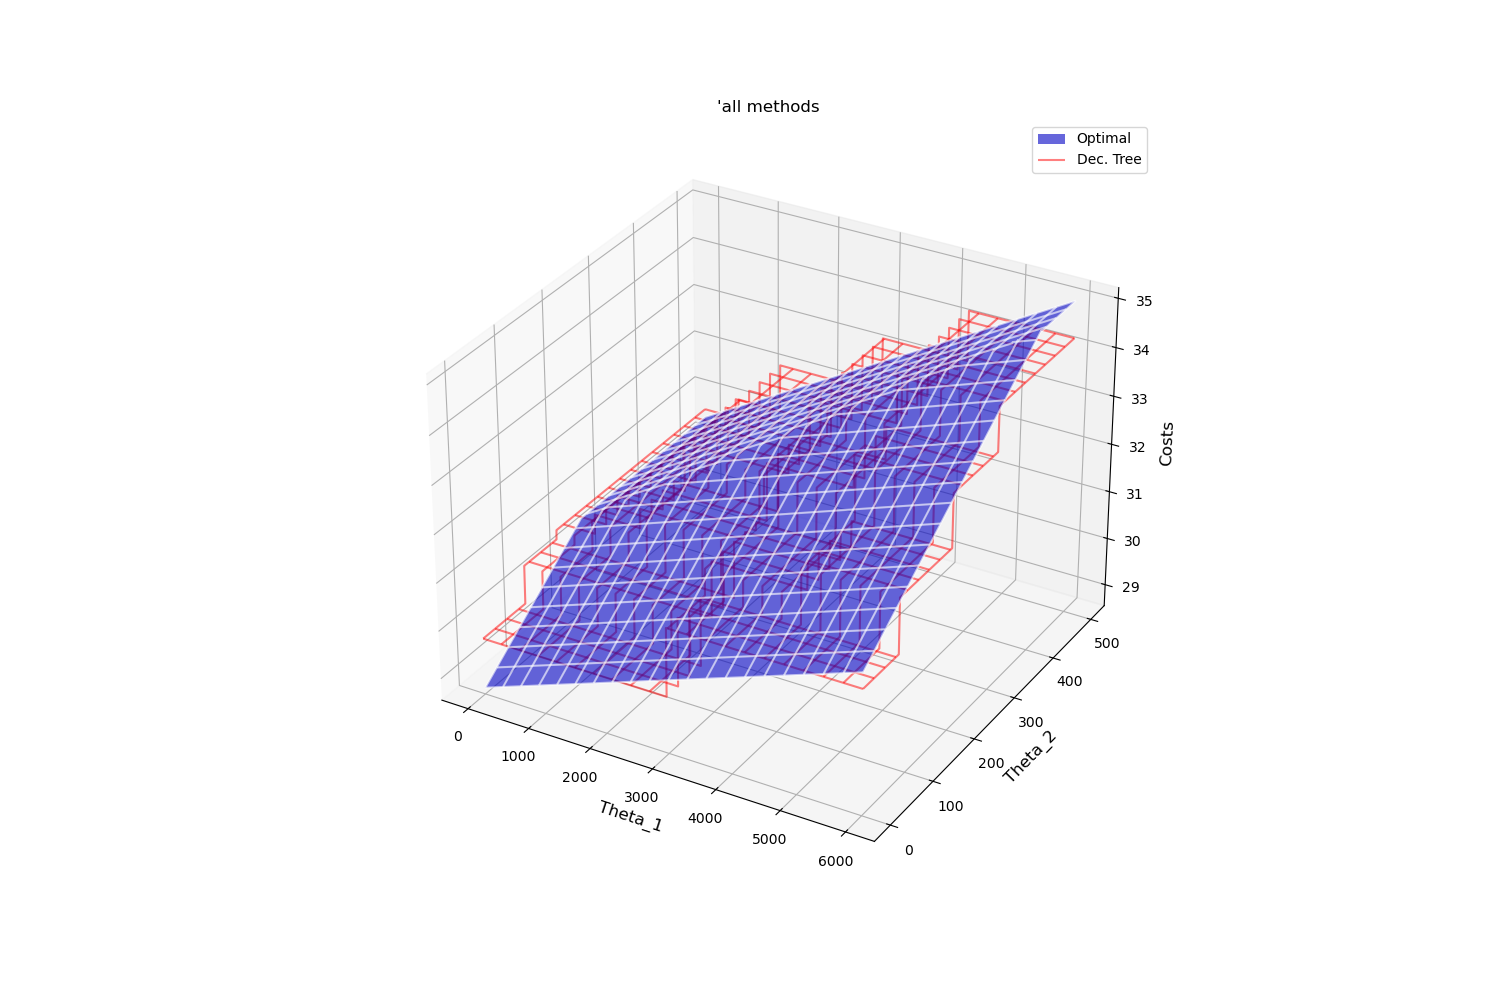

In [11]:
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(projection='3d')

z_lst   = [z_opt, z_lrg, z_DTR]
ttl_lst = ['Optimal', 'Lin. Reg.', 'Decision Tree']


ax.plot_surface(x, y, z_lst[0], rstride=50, cstride=50, label = 'Optimal', color = 'b', alpha = 0.6)
ax.plot_wireframe(x, y, z_lst[0], rstride=50, cstride=50, color = 'white', alpha = 0.6)
# ax.plot_wireframe(x, y, z_lst[1], rstride=50, cstride=50, label = 'Lin Reg', color = 'red', alpha = 0.5)
ax.plot_wireframe(x, y, z_lst[2], rstride=50, cstride=50, label = 'Dec. Tree', color = 'red', alpha=0.5)
ax.set_xlabel('Theta_1', fontsize=12)
ax.set_ylabel('Theta_2', fontsize=12)
ax.set_zlabel('Costs', fontsize=12)
ax.legend()
ax.set_title("'all methods", fontsize=12)

# Parametric decision variable

### nonlinear
min x 
st. x =>  lambda^2 
    x => -lambda^2

In [12]:
from scipy.optimize import minimize

In [15]:
# Fit linear regression model based on different kernel weights and apply it to [-1, 1] interval
x_test = np.linspace(start = -2.0, stop = 2.0, num=200).reshape(-1, 1)
outcome_d = {}

y_rel = []
for tst in x_test:
     y_rel.append(tst ** 2)

smpl_sclr = np.random.uniform(-2.0, 2.0, 100)
smpl_csts = []
krnl_wdth = [0.1, 0.25, 0.5, 0.75, 1, 1.25, 1.5]
smpl_wgts = np.zeros((len(krnl_wdth), len(smpl_sclr)))


for smpl in range(len(smpl_sclr)):
    for w in range(len(krnl_wdth)):
        locl_wgt = kernel(0, smpl_sclr[smpl], krnl_wdth[w])
        smpl_wgts[w][smpl] = locl_wgt
    
    loc_csts = smpl_sclr[smpl] **2
    smpl_csts.append(loc_csts)


for i in range(len(krnl_wdth)):
    clf = LinearRegression()
    clf.fit(np.array(smpl_sclr).reshape(-1, 1), np.array(smpl_csts), sample_weight=np.array(smpl_wgts[i]))
    y_test = clf.predict(x_test)
    outcome_d[str(krnl_wdth[i])] = y_test
    w_test = []
    for tst in x_test:
        w_test.append(kernel(tst, 0, krnl_wdth[i]))
    wMSE = mean_squared_error(y_rel, y_test, sample_weight=w_test)
    lcl_MSE = mean_squared_error(y_rel[50:-50], y_test[50:-50])
    print("Lin Reg. Kernel size: "+  str(krnl_wdth[i]), ".  wMSE: "+str( wMSE), ".  local MSE: "+str( lcl_MSE))

for i in range(len(krnl_wdth)):
    DRT = DecisionTreeRegressor(max_depth=4)
    DRT.fit(np.array(smpl_sclr).reshape(-1, 1), np.array(smpl_csts), sample_weight=np.array(smpl_wgts[i]))
    y_test = DRT.predict(x_test)
    outcome_d[str(krnl_wdth[i]) + 'DRT'] = y_test
    w_test = []
    for tst in x_test:
        w_test.append(kernel(tst, 0, krnl_wdth[i]))
    wMSE = mean_squared_error(y_rel, y_test, sample_weight=w_test)
    lcl_MSE = mean_squared_error(y_rel[50:-50], y_test[50:-50])
    print("DRT Kernel size: "+  str(krnl_wdth[i]), ".  wMSE: "+str( wMSE), ".  local MSE: "+str( lcl_MSE))

Lin Reg. Kernel size: 0.1 .  wMSE: 0.0002458004939861991 .  local MSE: 0.19301674987089715
Lin Reg. Kernel size: 0.25 .  wMSE: 0.008651503390609437 .  local MSE: 0.16573000697727072
Lin Reg. Kernel size: 0.5 .  wMSE: 0.1293487586963637 .  local MSE: 0.09154674034812155
Lin Reg. Kernel size: 0.75 .  wMSE: 0.5028387315052569 .  local MSE: 0.20144276436626515
Lin Reg. Kernel size: 1 .  wMSE: 0.8567463100548695 .  local MSE: 0.44337273745100686
Lin Reg. Kernel size: 1.25 .  wMSE: 1.0739193524512418 .  local MSE: 0.6740187682090466
Lin Reg. Kernel size: 1.5 .  wMSE: 1.1995126327430155 .  local MSE: 0.8490823782724587
DRT Kernel size: 0.1 .  wMSE: 9.027102372599539e-05 .  local MSE: 0.0723573237685506
DRT Kernel size: 0.25 .  wMSE: 0.0005070173637065224 .  local MSE: 0.003831752391157223
DRT Kernel size: 0.5 .  wMSE: 0.007298470684184445 .  local MSE: 0.008462307454097632
DRT Kernel size: 0.75 .  wMSE: 0.024379290505956483 .  local MSE: 0.024863446275921356
DRT Kernel size: 1 .  wMSE: 0.0484

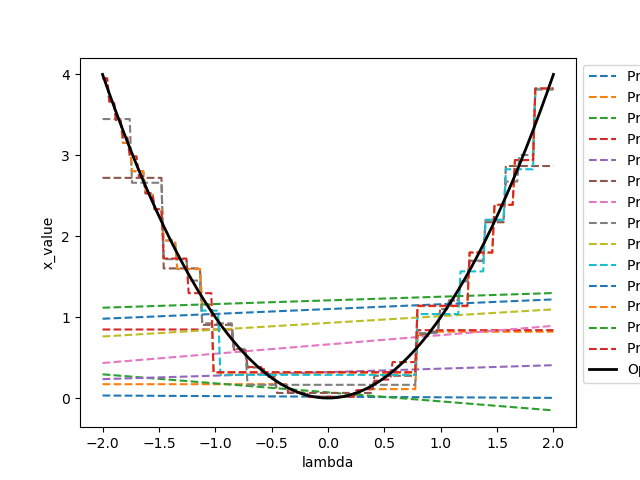

In [16]:
fig = plt.figure()
for kr_w in krnl_wdth[:]:
    plt.plot(x_test, outcome_d[str(kr_w)], label = 'Prediction Lin Reg, krnl width = ' + str(kr_w), linestyle = '--', linewidth =1.5) 
    plt.plot(x_test, outcome_d[str(kr_w)+ 'DRT'], label = 'Prediction Lin Reg, krnl width = ' + str(kr_w), linestyle = '--', linewidth =1.5) 
plt.plot(x_test, y_rel, color = 'black', linestyle = '-', label = "Optimal", linewidth =2) 
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left') 
plt.xlabel("lambda")
plt.ylabel("x_value") 
plt.show()